In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy import random
from numpy.fft import fft, fftshift
import statistics 
import h5py
from scipy.optimize import curve_fit
from scipy.signal import welch



In [2]:
# Open the HDF5 file in read mode
filename = "C:\\_Data\\LLqub_contT1\\2024-02-20_18-46-50.h5"
hf = h5py.File(filename, 'r')
# Initialize dictionaries to store datasets
datasets_t1_cont = {}
datasets_t1_recal = {}
# Loop through each group and store datasets in dictionaries
for group_name in hf.keys():
    group = hf[group_name]
    datasets_group = {}
    for dataset_name in group.keys():
        datasets_group[dataset_name] = np.array(group[dataset_name])
    if group_name == 't1_cont':
        datasets_t1_cont = datasets_group
    elif group_name == 't1_recal':
        datasets_t1_recal = datasets_group
# Close the HDF5 file
        
# Loop through each group and print the names of the datasets
for group_name in hf.keys():
    print("Group:", group_name)
    group = hf[group_name]
    for dataset_name in group.keys():
        print("  Dataset:", dataset_name)

        
hf.close()

C:\Users\slab\AppData\Local\Temp\ipykernel_13656\1732705629.py:12: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  datasets_group[dataset_name] = np.array(group[dataset_name])


Group: t1_cont
  Dataset: amp
  Dataset: i
  Dataset: q
Group: t1_recal
  Dataset: amp
  Dataset: amp_value
  Dataset: i
  Dataset: i_value
  Dataset: q
  Dataset: q_value


In [3]:
amp_data =datasets_t1_cont['amp']
q_data = datasets_t1_cont['q']
i_data = datasets_t1_cont['i']
length_array = len(amp_data)

q_recal = datasets_t1_recal['q']
i_recal = datasets_t1_recal['i']
amp_recal = datasets_t1_recal['amp']

q_value = datasets_t1_recal['q_value']
i_value = datasets_t1_recal['i_value']
amp_value = datasets_t1_recal['amp_value']

Import the data: 

1800
(36000000,)
(18,)


Text(0.5, 1.0, 'T1 recalibration')

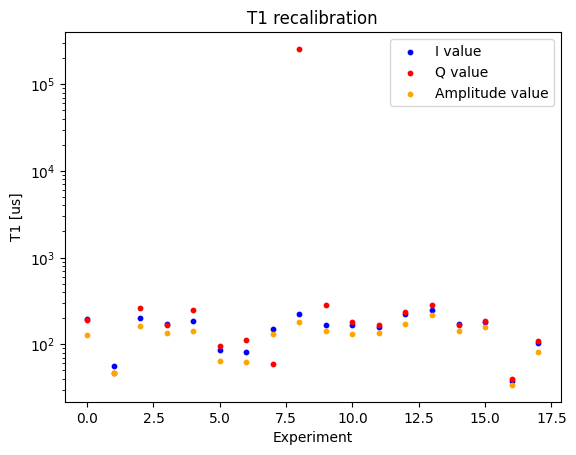

In [27]:
print(np.size(q_recal))
print(np.shape(q_data))
print(np.shape(q_value))

x_recal = np.arange(i_value.size)
plt.scatter(x_recal, i_value, s = 10, label = 'I value', color = 'blue')
plt.scatter(x_recal, q_value, s = 10, label = 'Q value', color = 'red')
plt.scatter(x_recal, amp_value, s = 10, label = 'Amplitude value', color = 'orange')
# make the y axis log scale
plt.yscale('log')
plt.legend()
plt.xlabel('Experiment')
plt.ylabel('T1 [us]')
plt.title('T1 recalibration')




In [6]:
pi_sigma = 0.05889005791993152 # [us]
T1 = 102.81912731303517 #[us]  ## FIX LATER --> MAKE IT THE ACTUAL T1 VALUE GIVEN DATA
readout_length = 15 # [us]
relax_delay = 1500 #[us]

pulse_length = 4*pi_sigma + T1 + readout_length + relax_delay # pulse length [us]
scan_length = length_array * pulse_length *(1E-6) * (1/3600) # length of scan [hr]


print(f'length of pulse {pulse_length} [us]')
print(f'length of scan {scan_length} [hr]')

length of pulse 1618.0546875447149 [us]
length of scan 16.18054687544715 [hr]


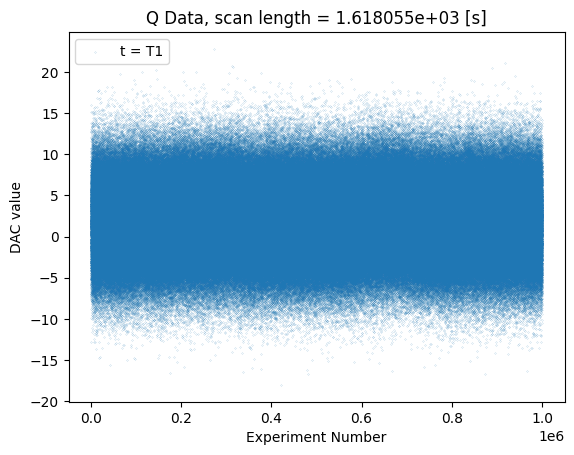

Text(0.5, 1.0, 'I Data, scan length = 1.618055e+03 [s]')

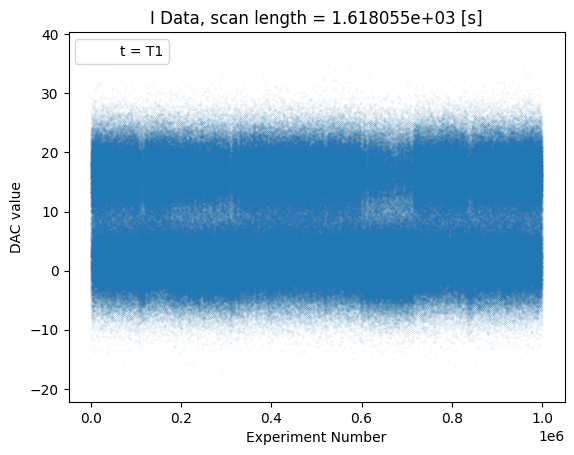

In [16]:
x_data = np.arange(q_data.size)
length_short_scan = 1000000
plt.scatter(x_data[0:length_short_scan], q_data[0:length_short_scan], s = 0.009, label = 't = T1')
plt.xlabel('Experiment Number')
plt.ylabel('DAC value')
plt.legend()
plt.title(f'Q Data, scan length = {"{:e}".format(pulse_length*length_short_scan*1E-6)} [s]')
plt.show() 

plt.scatter(x_data[0:length_short_scan], i_data[0:length_short_scan], s = 0.001, label = 't = T1')
plt.xlabel('Experiment Number')
plt.ylabel('DAC value')
plt.legend()
plt.title(f'I Data, scan length = {"{:e}".format(pulse_length*length_short_scan*1E-6)} [s]')

In [9]:

guess = [ 0.01, 0, 2, 0.04, -18, 2]


# Define the Gaussian function
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)

# Define the sum of two Gaussian functions
def two_gaussians(x, amp1, cen1, wid1, amp2, cen2, wid2):
    return gaussian(x, amp1, cen1, wid1) + gaussian(x, amp2, cen2, wid2)

# Your data
d = i_data[0:length_short_scan]

# Create the histogram data
hist, bin_edges = np.histogram(d, bins=300, density=True)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2


# Fit the histogram data to the sum of two Gaussian functions
params, params_covariance = curve_fit(two_gaussians, bin_centres, hist, p0=guess)

# Print the parameters
#[g amplitude, g center, g width, e amplitude, e center, e width]
print('e amplitude:',params[0],'\ne center:',params[1],'\ne width:',params[2], '\ng amplitude:', params[3],'\ng center:',params[4],'\ng width:',params[5], )

x_fit = np.linspace(bin_edges[0], bin_edges[-1], 1000)
y_fit = two_gaussians(x_fit, *params)



e amplitude: 0.03987695547614265 
e center: 9.51100028277167 
e width: 229.81675916600528 
g amplitude: -1.4017319677645708 
g center: -72.84758340030446 
g width: 94.45164595342881


c:\Users\slab\anaconda3\envs\slab\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


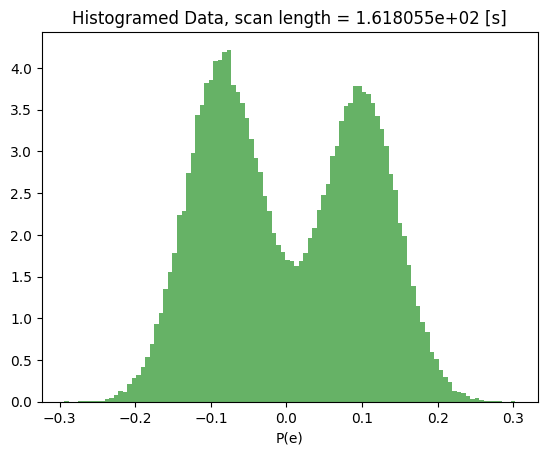

Text(0, 0.5, 'P(e)')

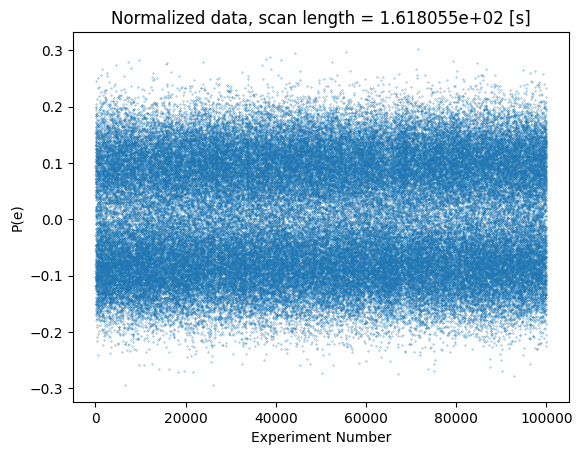

In [10]:
# Plot the histogram and the fitted function
# plt.hist(d, bins=100, density=True, alpha=0.6, color='g')
# plt.plot(x_fit, y_fit, 'r-')
# plt.axvline(x = params[1], color = 'r', label = 'e' )
# plt.axvline(x = params[4], color = 'b', label = 'g')
# plt.legend()
# plt.show()

dnorm = 1- (d - params[4])/(params[1]-params[4])
plt.hist(dnorm, bins=100, density=True, alpha=0.6, color='g')
plt.title(f'Histogramed Data, scan length = {"{:e}".format(pulse_length*length_short_scan*1E-6)} [s]')
# plt.plot(x_fit, y_fit, 'r-')
# plt.axvline(x = params[1], color = 'r', label = 'e' )
# plt.axvline(x = params[4], color = 'b', label = 'g')
# plt.legend()
plt.xlabel('P(e)')
plt.show()

plt.plot(dnorm,'.', markersize=0.5)
plt.title(f'Normalized data, scan length = {"{:e}".format(pulse_length*length_short_scan*1E-6)} [s]')
plt.xlabel('Experiment Number')
plt.ylabel('P(e)')


Text(0.5, 1.0, 'P(e) at t = T1')

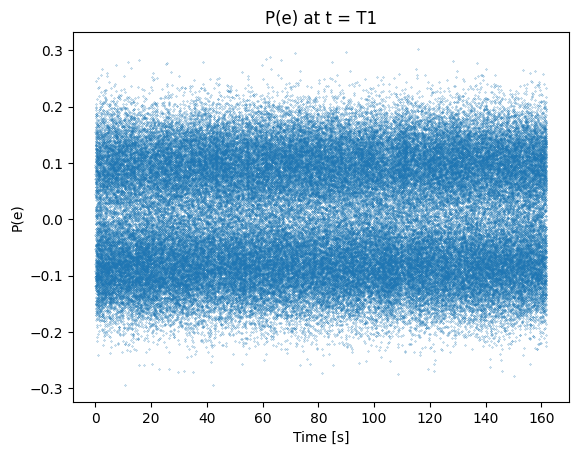

In [12]:
time_axis = x_data[0:length_short_scan] * pulse_length*1E-6 
plt.scatter(time_axis, dnorm, s = 0.05)
plt.xlabel('Time [s]')
plt.ylabel('P(e)')
plt.title('P(e) at t = T1')

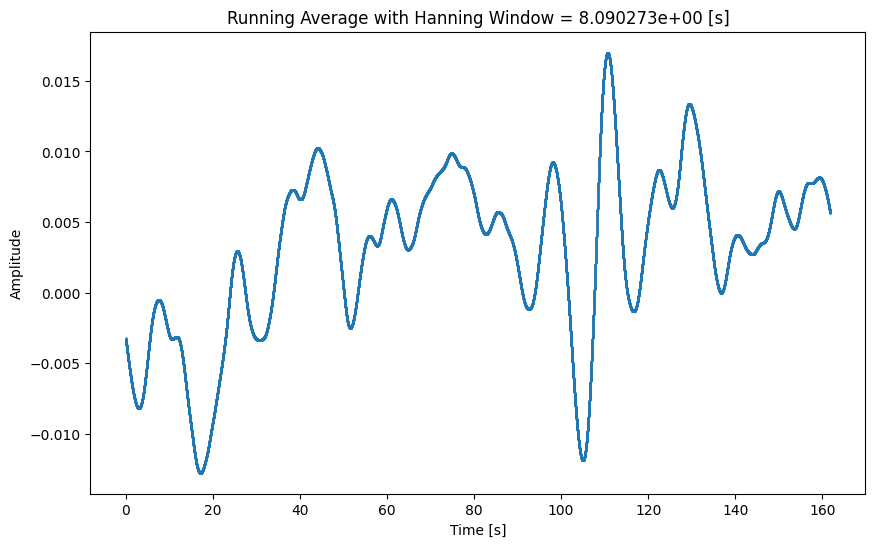

In [13]:
window_size = 5000
hanning_window = np.hanning(window_size) / np.sum(np.hanning(window_size))  # Normalize the window

# Apply running average using convolution
y_data_smoothed = np.convolve(dnorm, hanning_window, mode='same')

# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.plot(time_axis, y_data_smoothed,'.', markersize=0.5)
plt.xlabel('Time [s]')

plt.title(f'Running Average with Hanning Window = {"{:e}".format(window_size*pulse_length*1E-6)} [s]')
plt.ylabel('Amplitude')
# plt.legend()
plt.show()

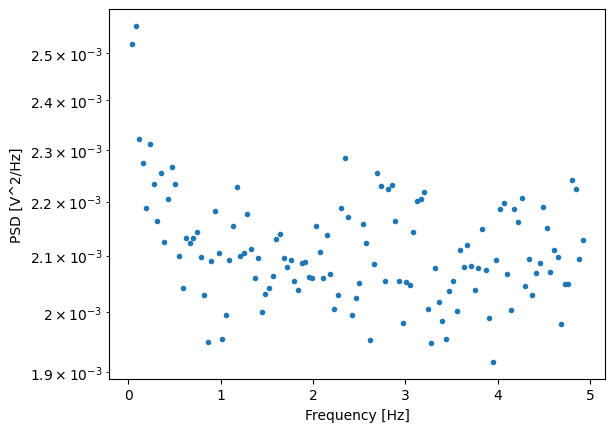

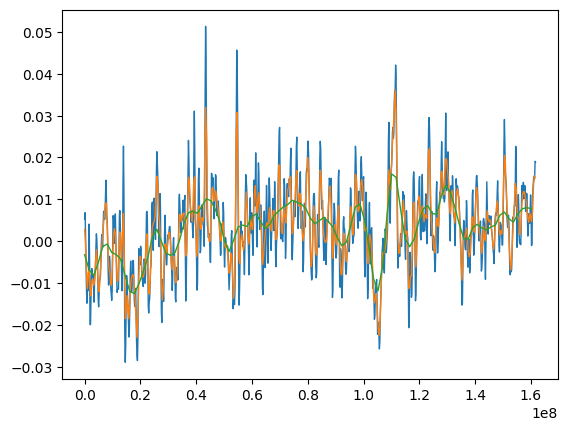

C:\Users\slab\AppData\Local\Temp\ipykernel_13656\4259778424.py:40: RuntimeWarning: invalid value encountered in log
  logA = np.mean(np.log(filt5k[1]))+1  # This tries to esimate the impact of imperfect prep
C:\Users\slab\AppData\Local\Temp\ipykernel_13656\4259778424.py:41: RuntimeWarning: invalid value encountered in log
  T1_norm_corr = 1/(logA - np.log(filt5k[1])) # Correcting for imperfect prep
C:\Users\slab\AppData\Local\Temp\ipykernel_13656\4259778424.py:43: RuntimeWarning: invalid value encountered in log
  T1_norm = - 1/np.log(filt5k[1]) # Not corrected


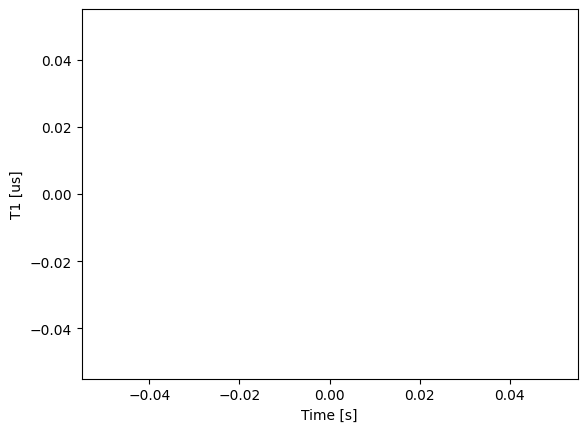

nan


In [14]:

# Compute the power spectral density of dnorm
# fs is sampling frequency, inverse of pulse period
frequencies, psd = welch(dnorm, fs=10)

# Plot the power spectral density
plt.semilogy(frequencies[1:-2], psd[1:-2],'.')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V^2/Hz]')
plt.show()

# %%
def hanning(y, window_size=80000):
    hanning_window = np.hanning(window_size) / np.sum(np.hanning(window_size))  # Normalize the window

    # Apply running average using convolution
    return np.convolve(y, hanning_window, mode='same')

def decimate(y, factor=1000):
    return y[::factor]

def filt_data(y, T, window): 
    yfilt = decimate(hanning(y, window), int(window/5))
    tfilt = np.arange(len(yfilt))*T*np.ceil(window/5)
    return tfilt, yfilt

T=pulse_length # gives correction time in us 

filt5k = filt_data(dnorm, T, 5000)
filt1k = filt_data(dnorm, T, 1000)
filt500 = filt_data(dnorm, T, 500)

plt.plot(filt500[0], filt500[1], linewidth=1)
plt.plot(filt1k[0], filt1k[1], linewidth=1)
plt.plot(filt5k[0], filt5k[1], linewidth=1)
plt.show()
# %%

# Convert to T1 
skip = 5
logA = np.mean(np.log(filt5k[1]))+1  # This tries to esimate the impact of imperfect prep 
T1_norm_corr = 1/(logA - np.log(filt5k[1])) # Correcting for imperfect prep 
T1_norm_corr = T1_norm_corr*T1
T1_norm = - 1/np.log(filt5k[1]) # Not corrected 
# plt.plot(T1_norm[skip:])
new_time = filt5k[0] * 1E-6 
plt.plot(new_time[skip:] , T1_norm_corr[skip:])
plt.ylabel('T1 [us]')
plt.xlabel('Time [s]')
plt.show()

# %% Check standard deviation normalized to T1
print(np.std(T1_norm_corr[5:])) 


Histogram the data

Text(0, 0.5, 'Amplitude')

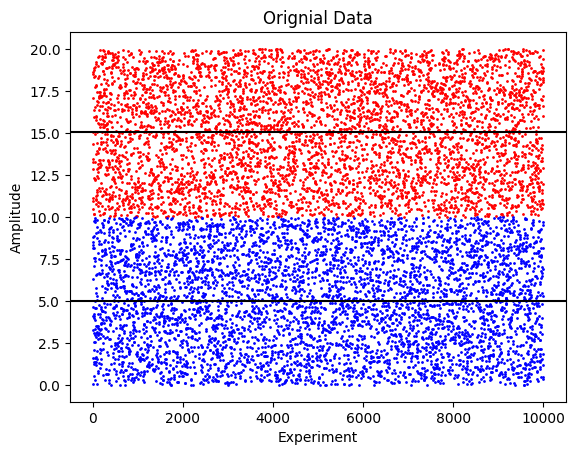

In [16]:
ge_threshold = 10
y_data_e = [] 
y_data_g = [] 
x_data_e = []
x_data_g = []

for i in range(len(y_data)):
    if y_data[i] >= ge_threshold:
        y_data_e.append(y_data[i])
        x_data_e.append(x_data[i])
    else:
        y_data_g.append(y_data[i])
        x_data_g.append(x_data[i])

# Convert the lists to NumPy arrays if needed
y_data_e = np.array(y_data_e)
y_data_g = np.array(y_data_g)

e_avg = np.average(y_data_e)
g_avg = np.average(y_data_g)

std_deve = statistics.stdev(y_data_e)
std_devg = statistics.stdev(y_data_g) 
# Create weighted arrays using Gaussian function
gaussian_weight_e = np.exp(-(y_data_e - e_avg)**2 / (2 * std_deve**2))
gaussian_weight_g = np.exp(-(y_data_g - g_avg)**2 / (2 * std_devg**2))

# Apply Gaussian weighting to the data
e_data_weighted = (y_data_e * gaussian_weight_e)
e_data_weighted = (y_data_e * gaussian_weight_e)/np.max(e_data_weighted)

g_data_weighted = (y_data_g * gaussian_weight_g)
g_data_weighted = (y_data_g * gaussian_weight_g)/np.max(g_data_weighted)

plt.scatter(x_data_e, y_data_e, color = 'red', label = 'e', s = 1)
plt.scatter(x_data_g, y_data_g, color = 'blue', label = 'g', s = 1)
plt.axhline(y=e_avg, color='black', linestyle='-', label = 'avg of e state')
plt.axhline(y=g_avg, color='black', linestyle='-', label = 'avg of g state')
plt.title('Orignial Data')
plt.xlabel('Experiment')
plt.ylabel('Amplitude')


Hanning on the original data

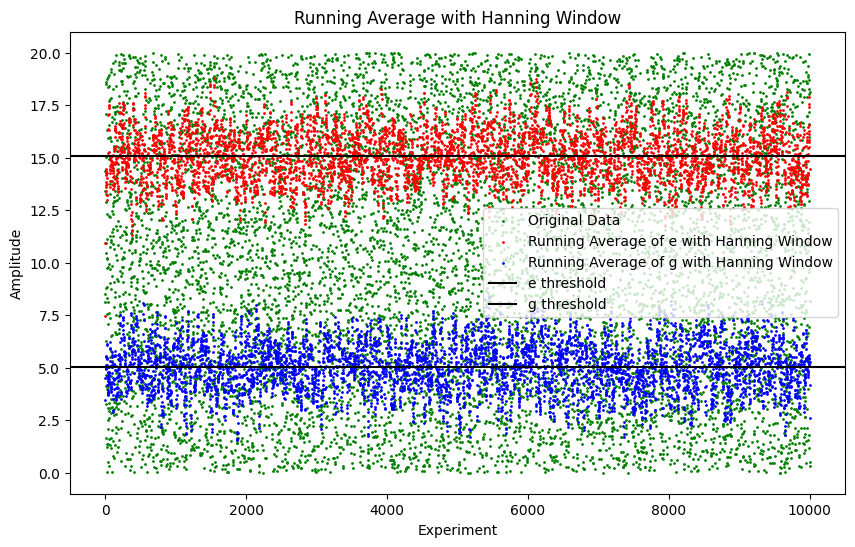

In [17]:
window_size = 10
hanning_window = np.hanning(window_size) / np.sum(np.hanning(window_size))  # Normalize the window

# Apply running average using convolution
y_data_smoothed_e = np.convolve(y_data_e, hanning_window, mode='same')
y_data_smoothed_g = np.convolve(y_data_g, hanning_window, mode = 'same')
# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Original Data', color = 'green', s = 1)
plt.scatter(x_data_e, y_data_smoothed_e, label='Running Average of e with Hanning Window', color = 'red', s = 1)
plt.scatter(x_data_g, y_data_smoothed_g, label='Running Average of g with Hanning Window', color = 'blue', s =1)
plt.axhline(y=e_avg, color='black', linestyle='-', label = 'e threshold')
plt.axhline(y=g_avg, color='black', linestyle='-', label = 'g threshold')
plt.title('Running Average with Hanning Window')
plt.xlabel('Experiment')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Hanning on the histogramed data

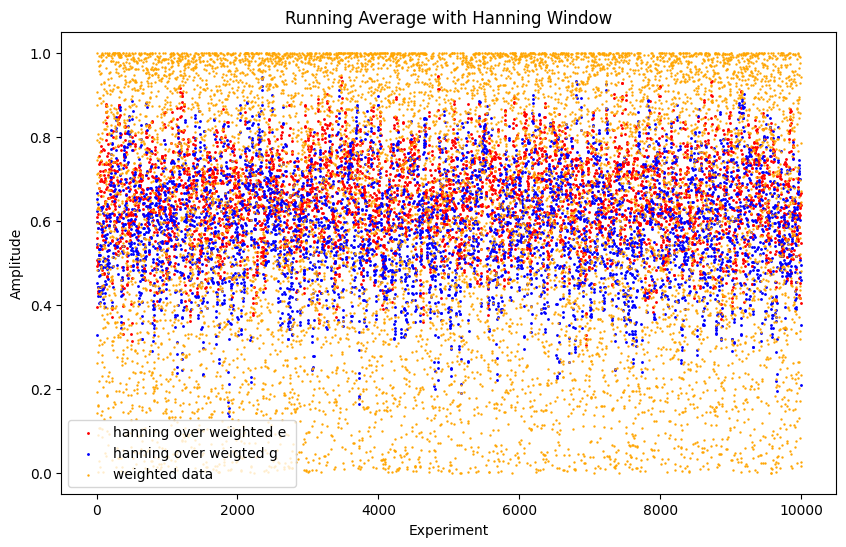

In [20]:
window_size = 10
hanning_window = np.hanning(window_size) / np.sum(np.hanning(window_size))  # Normalize the window

# Apply running average using convolution
y_data_smoothed_e = np.convolve(e_data_weighted, hanning_window, mode='same')
y_data_smoothed_g = np.convolve(g_data_weighted, hanning_window, mode = 'same')
# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.scatter(x_data_e, y_data_smoothed_e, label='hanning over weighted e ', color = 'red', s = 1.1)
plt.scatter(x_data_g, y_data_smoothed_g, label='hanning over weigted g', color = 'blue', s =1.1)
plt.scatter(x_data_e, e_data_weighted, color = 'orange', label = 'weighted data', s = 0.5 )
plt.scatter(x_data_g, g_data_weighted, color = 'orange', s =0.5 )

plt.title('Running Average with Hanning Window')
plt.xlabel('Experiment')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [90]:
import csv

# List to store the rows
all_rows = []
results = []
with open("t1_i_03.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    for column in reader:
        # Append each row to the list
        all_rows.append(row)

print('Downloaded the CSV.')


Downloaded the CSV.


In [107]:
import numpy as np

# Read data from CSV file
data = np.loadtxt('t1_q03.csv')

# Print the loaded data
# print(data)

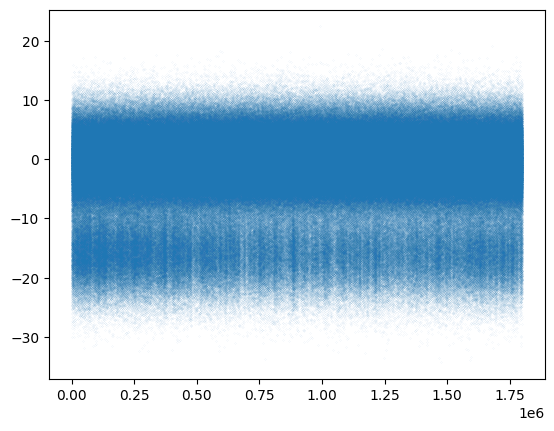

In [108]:
plt.plot(data, '.', markersize=0.05)

In [104]:
pulse_time = (4*0.05889005791993152 + 211.8234892547973 + 15.0 + 2000.0)*1e-6 # in seconds

In [106]:
print(len(data)*pulse_time/3600)

0.5567647623716192


In [63]:
print(np.size(all_rows[2]))

20000


In [64]:
print(np.size(all_rows[3]))

40000


In [53]:
print(np.size(all_rows[4]))

0


In [75]:
plt.plot(t1_cont.data['raw_i'])

NameError: name 't1_cont' is not defined

In [54]:
print(np.size(all_rows[5]))

IndexError: list index out of range

In [1]:
import h5py


In [2]:
with h5py.File('2024-02-09_13-00-17.h5', 'r') as f:
    d1 = f['array_1']
    d2 = f['array_2']

OSError: Unable to open file (bad object header version number)

In [7]:
import numpy as np 

In [19]:
filename = "C:\_Data\LLqub_contT1\data.h5"
hf = h5py.File(filename, 'r')


In [20]:

filename = "C:\_Data\LLqub_contT1\data.h5"
hf = h5py.File(filename, 'r')

# Initialize dictionaries to store datasets
datasets_t1_cont = {}
datasets_t1_recal = {}

# Loop through each group and store datasets in dictionaries
for group_name in hf.keys():
    group = hf[group_name]
    datasets_group = {}
    for dataset_name in group.keys():
        datasets_group[dataset_name] = np.array(group[dataset_name])
    if group_name == 't1_cont':
        datasets_t1_cont = datasets_group
    elif group_name == 't1_recal':
        datasets_t1_recal = datasets_group

# Close the HDF5 file
hf.close()

C:\Users\slab\AppData\Local\Temp\ipykernel_4144\2642946530.py:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  datasets_group[dataset_name] = np.array(group[dataset_name])


In [21]:
print(datasets_t1_cont.keys())

dict_keys(['amp', 'i', 'q'])


In [23]:
print(np.shape(datasets_t1_cont['amp']))

(108000000,)
